<a href="https://colab.research.google.com/github/gargarushee/techfutures_workshop/blob/main/Exercise2_travel_itenary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# SECTION 1: SETUP AND INSTALLATION
# ============================================================================

# Install required packages
!pip install langgraph
!pip install langsmith
!pip install langchain-openai
!pip install langgraph_supervisor
!pip install python-dotenv
!pip install langchain_google_genai

https://github.com/gargarushee/multiAgentHandsOnExcerciseTechFutures

Setup API KEYS!!

1. OPENAI_API_KEY https://platform.openai.com/api-keys
2. TAVILY_SEARCH Sign up at https://www.tavily.com/ to get API KEY access for web search

In [ ]:
# Set your API keys here
OPENAI_API_KEY = ""
TAVILY_API_KEY = ""
LANGSMITH_API_KEY = ""

In [ ]:
import os

# IPython display components for visualization
from IPython.display import Image, display

In [ ]:
# =============================================================================
# ENVIRONMENT SETUP
# =============================================================================

def _set_env(var: str, value: str) -> None:
  os.environ[var] = value

# Set API keys from the variables defined earlier
_set_env("OPENAI_API_KEY", OPENAI_API_KEY)
_set_env("LANGSMITH_API_KEY", LANGSMITH_API_KEY)
_set_env("TAVILY_API_KEY", TAVILY_API_KEY)


# Optional: Enable LangSmith tracing for observability
# This allows us to trace and debug our agent interactions
os.environ["LANGCHAIN_TRACING_V2"] = "true"

**Supervisor (tool-calling)¶**
In this variant of the supervisor architecture, we define a supervisor agent which is responsible for calling sub-agents. The sub-agents are exposed to the supervisor as tools, and the supervisor agent decides which tool to call next. The supervisor agent follows a standard implementation as an LLM running in a while loop calling tools until it decides to stop.


# Multi-Agent Travel Itinerary System using LangGraph

This system includes:
- Supervisor Node: Routes to appropriate agents
- Generic Planner: Creates overall trip structure
- Weather Planner: Adds weather-based recommendations
- Restaurant Planner: Suggests dining options




In [ ]:
from typing import TypedDict, Annotated, Literal
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import operator
import os

In [ ]:
# Define the shared state
class TravelState(TypedDict):
    """State shared across all agents"""
    destination: str
    duration: str
    user_request: str
    current_plan: Annotated[list[str], operator.add]
    weather_info: str
    restaurant_info: str
    next_agent: str
    completed_agents: Annotated[list[str], operator.add]


In [ ]:

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)


In [ ]:
# Agents
def generic_planner_agent(state: TravelState) -> dict:
    """Creates a generic travel itinerary"""
    print("\n🗺️  Generic Planner is working...")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a travel planning expert. Create a day-by-day itinerary outline
        for the given destination and duration. Include key attractions, activities, and
        general timing. Be concise but informative."""),
        ("user", "Destination: {destination}\nDuration: {duration}\nRequest: {user_request}")
    ])

    response = llm.invoke(prompt.format_messages(
        destination=state["destination"],
        duration=state["duration"],
        user_request=state["user_request"]
    ))

    plan = f"Generic Plan:\n{response.content}"

    return {
        "current_plan": [plan],
        "completed_agents": ["generic_planner"]
    }


def weather_planner_agent(state: TravelState) -> dict:
    """Adds weather considerations to the itinerary"""
    print("\n🌤️  Weather Planner is working...")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a weather-aware travel advisor. Based on typical weather patterns
        for the destination and season, suggest appropriate activities, clothing, and timing
        adjustments. Consider both indoor and outdoor options."""),
        ("user", """Destination: {destination}
Duration: {duration}
Current Plan: {current_plan}

Provide weather-based recommendations and activity adjustments.""")
    ])

    response = llm.invoke(prompt.format_messages(
        destination=state["destination"],
        duration=state["duration"],
        current_plan="\n".join(state.get("current_plan", []))
    ))

    weather_additions = f"\n\nWeather Considerations:\n{response.content}"

    return {
        "current_plan": [weather_additions],
        "weather_info": response.content,
        "completed_agents": ["weather_planner"]
    }


def restaurant_planner_agent(state: TravelState) -> dict:
    """Adds restaurant and dining recommendations"""
    print("\n🍽️  Restaurant Planner is working...")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a culinary travel expert. Recommend restaurants, cafes, and
        local dining experiences for each day of the trip. Include a mix of local specialties,
        popular spots, and hidden gems. Mention cuisine types and approximate meal times."""),
        ("user", """Destination: {destination}
Duration: {duration}
Current Plan: {current_plan}

Suggest dining options for each day.""")
    ])

    response = llm.invoke(prompt.format_messages(
        destination=state["destination"],
        duration=state["duration"],
        current_plan="\n".join(state.get("current_plan", []))
    ))

    restaurant_additions = f"\n\nDining Recommendations:\n{response.content}"

    return {
        "current_plan": [restaurant_additions],
        "restaurant_info": response.content,
        "completed_agents": ["restaurant_planner"]
    }


def supervisor_agent(state: TravelState) -> dict:
    """
    Supervisor that determines which agent should run next.
    Routes based on which agents have already completed.
    """
    print("\n🎯 Supervisor is routing...")

    completed = set(state.get("completed_agents", []))

    # Define the order of execution
    agent_order = ["generic_planner", "weather_planner", "restaurant_planner"]

    # Find the next agent to run
    for agent in agent_order:
        if agent not in completed:
            print(f"   → Routing to: {agent}")
            return {"next_agent": agent}

    # All agents completed
    print("   → All agents completed. Finishing up!")
    return {"next_agent": "finalize"}


def synthesizer_agent(state: TravelState) -> dict:
    """Combines all plans into a final itinerary"""
    print("\n✅ Finalizing itinerary...")

    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a professional travel coordinator. Combine the following planning
        elements into a cohesive, well-formatted final travel itinerary. Make it clear,
        organized by day, and easy to follow."""),
        ("user", """Destination: {destination}
Duration: {duration}

Planning Components:
{current_plan}

Create a final, polished itinerary.""")
    ])

    response = llm.invoke(prompt.format_messages(
        destination=state["destination"],
        duration=state["duration"],
        current_plan="\n".join(state.get("current_plan", []))
    ))

    final_plan = f"\n\n{'='*60}\n🎉 FINAL TRAVEL ITINERARY\n{'='*60}\n\n{response.content}"

    return {
        "current_plan": [final_plan]
    }


In [ ]:
# Routing function for conditional edges
def route_supervisor(state: TravelState) -> Literal["generic_planner", "weather_planner", "restaurant_planner", "finalize", "__end__"]:
    """Routes from supervisor to the appropriate next node"""
    next_agent = state.get("next_agent", "")

    if next_agent == "generic_planner":
        return "generic_planner"
    elif next_agent == "weather_planner":
        return "weather_planner"
    elif next_agent == "restaurant_planner":
        return "restaurant_planner"
    elif next_agent == "finalize":
        return "finalize"
    else:
        return END

In [ ]:
# Build the graph
def create_travel_itinerary_graph():
    """Creates and returns the compiled LangGraph"""

    workflow = StateGraph(TravelState)

    # Add nodes
    workflow.add_node("supervisor", supervisor_agent)
    workflow.add_node("generic_planner", generic_planner_agent)
    workflow.add_node("weather_planner", weather_planner_agent)
    workflow.add_node("restaurant_planner", restaurant_planner_agent)
    workflow.add_node("finalize", synthesizer_agent)

    # Set entry point
    workflow.set_entry_point("supervisor")

    # Add conditional edges from supervisor
    workflow.add_conditional_edges(
        "supervisor",
        route_supervisor,
        {
            "generic_planner": "generic_planner",
            "weather_planner": "weather_planner",
            "restaurant_planner": "restaurant_planner",
            "finalize": "finalize",
            END: END
        }
    )

    # Each agent returns to supervisor for next routing decision
    workflow.add_edge("generic_planner", "supervisor")
    workflow.add_edge("weather_planner", "supervisor")
    workflow.add_edge("restaurant_planner", "supervisor")

    # Finalize goes to END
    workflow.add_edge("finalize", END)

    return workflow.compile()

In [ ]:

# Main execution function
def generate_travel_itinerary(destination: str, duration: str, user_request: str = ""):
    """
    Generate a complete travel itinerary using the multi-agent system

    Args:
        destination: Where to travel (e.g., "Paris, France")
        duration: Length of trip (e.g., "3 days", "1 week")
        user_request: Additional user preferences (e.g., "I love museums and history")

    Returns:
        Complete itinerary as a string
    """

    # Create the graph
    graph = create_travel_itinerary_graph()

    # Initial state
    initial_state = {
        "destination": destination,
        "duration": duration,
        "user_request": user_request if user_request else "Standard tourist experience",
        "current_plan": [],
        "weather_info": "",
        "restaurant_info": "",
        "next_agent": "",
        "completed_agents": []
    }

    print(f"\n{'='*60}")
    print(f"🌍 GENERATING TRAVEL ITINERARY")
    print(f"{'='*60}")
    print(f"Destination: {destination}")
    print(f"Duration: {duration}")
    print(f"Preferences: {user_request if user_request else 'Standard tourist experience'}")
    print(f"{'='*60}\n")

    # Run the graph
    result = graph.invoke(initial_state)

    # Return the complete plan
    return "\n".join(result["current_plan"])

In [ ]:

# Example usage
if __name__ == "__main__":
    # Make sure to set your OpenAI API key
    # os.environ["OPENAI_API_KEY"] = "your-api-key"

    # Example 1: Simple trip
    print("\n" + "="*80)
    print("EXAMPLE 1: Weekend in Tokyo")
    print("="*80)

    itinerary = generate_travel_itinerary(
        destination="Tokyo, Japan",
        duration="3 days",
        user_request="I love technology, anime culture, and traditional temples"
    )

    print("\n" + itinerary)

    # Example 2: Another trip
    print("\n\n" + "="*80)
    print("EXAMPLE 2: Week in Italy")
    print("="*80)

    itinerary2 = generate_travel_itinerary(
        destination="Rome, Italy",
        duration="5 days",
        user_request="I'm interested in ancient history, art, and authentic Italian cuisine"
    )

    print("\n" + itinerary2)



EXAMPLE 1: Weekend in Tokyo

🌍 GENERATING TRAVEL ITINERARY
Destination: Tokyo, Japan
Duration: 3 days
Preferences: I love technology, anime culture, and traditional temples


🎯 Supervisor is routing...
   → Routing to: generic_planner

🗺️  Generic Planner is working...

🎯 Supervisor is routing...
   → Routing to: weather_planner

🌤️  Weather Planner is working...

🎯 Supervisor is routing...
   → Routing to: restaurant_planner

🍽️  Restaurant Planner is working...

🎯 Supervisor is routing...
   → All agents completed. Finishing up!

✅ Finalizing itinerary...

Generic Plan:
### 3-Day Itinerary for Tokyo, Japan

#### Day 1: Traditional Temples and Culture
- **Morning:**
  - **Senso-ji Temple** (Asakusa)
    - Arrive early to explore Japan's oldest temple.
    - Stroll through Nakamise Street for traditional snacks and souvenirs.
  
- **Lunch:**
  - Enjoy a meal at a local soba noodle shop in Asakusa.

- **Afternoon:**
  - **Tokyo Skytree**
    - Visit the observation deck for panoramic v

🎨 Generating workflow diagram...


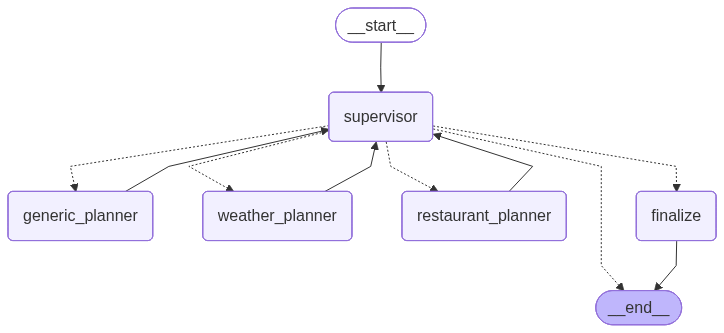

In [ ]:
# =============================================================================
# WORKFLOW VISUALIZATION
# =============================================================================

print("🎨 Generating workflow diagram...")
workflow_diagram = create_travel_itinerary_graph().get_graph().draw_mermaid_png()
display(Image(workflow_diagram))